In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
data=pd.read_csv('~\Downloads\daily_data.csv')
data

,datetime,high,low,close,open,volume
0,2018-01-01,13818.55,12750.00,13135.00,13715.65,6970.441076
1,2018-01-02,14750.00,12890.02,14580.00,13135.00,16359.347340
2,2018-01-03,15473.49,14150.00,14749.97,14576.87,19457.238601
3,2018-01-04,15280.00,13918.04,14811.00,14710.00,18783.876561
4,2018-01-05,17118.13,14600.00,16579.00,14805.01,22383.657333
...,...,...,...,...,...,...
1468,2022-01-08,42246.37,40501.00,40679.82,41707.04,27031.900870
1469,2022-01-09,42300.00,40520.00,41966.99,40679.82,27291.009660
1470,2022-01-10,42786.70,39650.00,41604.58,41966.99,51064.904360
1471,2022-01-11,43100.00,41158.99,42755.00,41604.58,38062.818280


In [3]:
def get_macd(price,slow,fast,smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1-exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    frames =  [macd, signal]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

macd=get_macd(data.close,26,12,9)
macd

,macd,signal
0,0.000000,0.000000
1,115.270655,23.054131
2,217.827657,62.008836
3,300.564708,109.720011
4,502.998982,188.375805
...,...,...
1468,-2136.672368,-1568.284564
1469,-2233.642180,-1701.356087
1470,-2313.071268,-1823.699123
1471,-2257.170852,-1910.393469


In [4]:
def generate_signal_for_macd(df,data):
    datetime=[]
    signal=[]
    current=0
    datetime.append(data.datetime[0])
    signal.append(0)
    for i in range(1,len(df.macd)):
        if(df.macd[i]>=df.signal[i] ):
            datetime.append(data.datetime[i])
            signal.append(1)
        elif(df.macd[i]<=df.signal[i]):
            datetime.append(data.datetime[i])
            signal.append(-1)
        else:
            datetime.append(data.datetime[i])
            signal.append(0)
    a=pd.DataFrame(columns=['datetime','signals'])
    a['datetime']=datetime
    a['signals']=signal
    return a
            
        
        
output=generate_signal_for_macd(macd,data)
output

,datetime,signals
0,2018-01-01,0
1,2018-01-02,1
2,2018-01-03,1
3,2018-01-04,1
4,2018-01-05,1
...,...,...
1468,2022-01-08,-1
1469,2022-01-09,-1
1470,2022-01-10,-1
1471,2022-01-11,-1


In [101]:
def compounding_with_stop_loss(data,output,stop_loss_percent=0.05,take_profit_percent=0.03):
    capital=1000 #this is the initial capital
    portfolio_value=[]
    datetime=[]
    quantity=[] #number of stocks
    current=0
    number_of_stock=0
    stop_loss=0
#     stop_loss_percent=0.02
    entry=[]
    exit=[]
    duration=[]
    signal=[]
    count=0 #stop loss count
    count1=0 #takeprofit count
    current_value=0 #for trailing stop loss if stop loss has to be updated
    trade_type=[]
    drawdown=[]
    commision_rate=1
    dip=[]
    take_profit=0
#     take_profit_percent=0.01
    for i in range(len(output.signals)-1):
        if(capital<0):
            print("Capital wiped")
            break
        datetime.append(data.datetime[i])
        if(current==0):
            if(output.signals[i]==0):
                signal.append(0)
                quantity.append(0)
                portfolio_value.append(capital)
                continue
            elif(output.signals[i]==1):
                signal.append(1)
                trade_type.append('long')
                current_value=capital
                portfolio_value.append(capital)
                current=1
                number_of_stock=(capital/data.close[i])
                take_profit=(1+take_profit_percent)*(capital)
                quantity.append(number_of_stock)
                stop_loss=(1-stop_loss_percent)*(capital)
                capital=0
                entry.append(i)
                
            else:
                current_value=capital
                trade_type.append('short')
                signal.append(-1)
                portfolio_value.append(capital)
                take_profit=(1-take_profit_percent)*(capital)
                current=-1
                number_of_stock=(capital/data.close[i])
                quantity.append(number_of_stock)
                stop_loss=(1+stop_loss_percent)*capital
                capital=2*capital
                entry.append(i)
        elif(current==1):
            if(output.signals[i]==0 or output.signals[i]==1):
                capital=capital+(number_of_stock*data.close[i])
                portfolio_value.append(capital)
                quantity.append(number_of_stock)
                if(capital<stop_loss):
                    signal.append(-1)
                    count=count+1
                    current=0
                    exit.append(i)
                    x=entry[-1]
                    lambda1=0 #what is the max drawdown
                    current_max=data.close[x] #what is the max for the range under consideration
                    for y in range(x+1,i+1):
                        if(data.close[y]>current_max):
                            current_max=data.close[y]
                    
                        temp=(100*(1-(data.close[y]/current_max)))
                        if(temp>lambda1):
                            lambda1=temp
            
                
                    drawdown.append(lambda1)
                    dip.append(100*((data.close[x]-np.min(data.close[x:i+1])*number_of_stock))/data.close[x])
                    continue
                elif(capital>=take_profit):
                    signal.append(-1)
                    count1=count1+1
                    current=0
                    exit.append(i)
                    x=entry[-1]
                    lambda1=0 #what is the max drawdown
                    current_max=data.close[x] #what is the max for the range under consideration
                    for y in range(x+1,i+1):
                        if(data.close[y]>current_max):
                            current_max=data.close[y]
                    
                        temp=(100*(1-(data.close[y]/current_max)))
                        if(temp>lambda1):
                            lambda1=temp
            
                
                    drawdown.append(lambda1)
                    dip.append(100*((data.close[x]-np.min(data.close[x:i+1])*number_of_stock))/data.close[x])
                    continue
                elif(capital>current_value):
                    signal.append(0)
                    current_value=capital
                    stop_loss=(1-stop_loss_percent)*(current_value)
                    
                else:
                    signal.append(0)
                capital=capital-(number_of_stock*data.close[i])
                
            
                
            else:
                quantity.append(number_of_stock)
                capital=capital+(number_of_stock*data.close[i])
                portfolio_value.append(capital)
                signal.append(-1)
                
                current=0
                exit.append(i)
                x=entry[-1]
                lambda1=0
                current_max=data.close[x]
                for y in range(x+1,i+1):
                    if(data.close[y]>current_max):
                        current_max=data.close[y]
                    
                    temp=(100*(1-(data.close[y]/current_max)))
                    if(temp>lambda1):
                        lambda1=temp
            
                
                drawdown.append(lambda1)
                dip.append(100*((data.close[x]-np.min(data.close[x:i+1])*number_of_stock))/data.close[x])
                number_of_stock=0
                
            
        else:
            quantity.append(number_of_stock)
            if(output.signals[i]==0 or output.signals[i]==-1):
                capital=capital-(number_of_stock*data.close[i])
                portfolio_value.append(capital)
                if(capital>stop_loss):
                    signal.append(1)
                    count=count+1
                    current=0
                    exit.append(i)
                    x=entry[-1]
                    lambda1=0
                    current_max=data.close[x]
                    for y in range(x+1,i+1):
                        if(data.close[y]<current_max):
                            current_max=data.close[y]
                    
                        temp=(100*((data.close[y]/current_max)-1))
                        if(temp>lambda1):
                            lambda1=temp
            
                
                    drawdown.append(lambda1)
                    dip.append(100*(np.max(data.close[x:i+1]-data.close[x])*number_of_stock)/data.close[x])
                    continue
                elif(capital<=take_profit):
                    signal.append(1)
                    count1=count1+1
                    current=0
                    exit.append(i)
                    x=entry[-1]
                    lambda1=0
                    current_max=data.close[x]
                    for y in range(x+1,i+1):
                        if(data.close[y]<current_max):
                            current_max=data.close[y]
                    
                        temp=(100*((data.close[y]/current_max)-1))
                        if(temp>lambda1):
                            lambda1=temp
            
                
                    drawdown.append(lambda1)
                    dip.append(100*(np.max(data.close[x:i+1]-data.close[x])*number_of_stock)/data.close[x])
                    continue
                elif(capital<current_value):
                    signal.append(0)
                    current_value=capital
                    stop_loss=(1+stop_loss_percent)*(current_value)
                else:
                    signal.append(0)
                capital=capital+(number_of_stock*data.close[i])
            else:
                capital=capital-(number_of_stock*data.close[i])
                portfolio_value.append(capital)
                signal.append(1)
                
                current=0
                exit.append(i)
                x=entry[-1]
                lambda1=0
                current_max=data.close[x]
                for y in range(x+1,i+1):
                    if(data.close[y]>current_max):
                        current_max=data.close[y]
                    
                    temp=(100*((data.close[y]/current_max)-1))
                    if(temp>lambda1):
                        lambda1=temp
            
                
                drawdown.append(lambda1)
                dip.append(100*(np.max(data.close[x:i+1]-data.close[x])*number_of_stock)/data.close[x])
                number_of_stock=0
                          
    a=len(data.datetime)-1
    datetime.append(data.datetime[a])
    quantity.append(number_of_stock)
    if(current==1):
        exit.append(a)
        capital=capital+(number_of_stock*data.close[a])
        signal.append(-1)
        x=entry[-1]
        lambda1=0
        current_max=data.close[x]
        for y in range(x+1,a+1):
            if(data.close[y]>current_max):
                current_max=data.close[y]
                    
            temp=(100*(1-(data.close[y]/current_max)))
            if(temp>lambda1):
                lambda1=temp
            
                
        drawdown.append(lambda1)
        dip.append(100*((data.close[x]-np.min(data.close[x:i+1])*number_of_stock))/data.close[x])
    elif(current==-1):
        exit.append(a)
        capital=capital-(number_of_stock*data.close[a])
        signal.append(1)
        x=entry[-1]
        lambda1=0
        current_max=data.close[x]
        for y in range(x+1,a+1):
                
            if(data.close[y]<current_max):
                current_max=data.close[y]
                    
            temp=(100*((data.close[y]/current_max)-1))
            if(temp>lambda1):
                lambda1=temp
                
            
                
        drawdown.append(lambda1)
        dip.append(100*(np.max(data.close[x:i+1]-data.close[x])*number_of_stock)/data.close[x])
    else:
        signal.append(0)
    portfolio_value.append(capital)
        
        
    
    to_submit=pd.DataFrame(columns=['datetime'])
    to_submit['datetime']=datetime
    to_submit['signals']=signal
    to_submit['open']=data.open
    
    to_submit['high']=data.high
    to_submit['low']=data.low
    to_submit['close']=data.close
    to_submit['volume']=data.volume
    duration=[]
    returns=[]
    PL_in_dollars=[]
    
    
        
    for i in range(len(entry)):
        duration.append(exit[i]-entry[i])
        returns.append(100*((portfolio_value[exit[i]]/portfolio_value[entry[i]])-1))
        PL_in_dollars.append(portfolio_value[exit[i]]-portfolio_value[entry[i]])
        
    trade_wise=pd.DataFrame(columns=['entry','exit','duration','returns'])
    trade_wise['entry']=entry
    trade_wise['exit']=exit
    trade_wise['duration']=duration
    trade_wise['returns']=returns
    trade_wise['type']=trade_type
    trade_wise['drawdown']=drawdown
    
    every_day=pd.DataFrame(columns=['datetime','portfolio value','quantity'])
    every_day['datetime']=datetime
    every_day['portfolio value']=portfolio_value
    every_day['quantity']=quantity
    every_day['daily_return'] = every_day['portfolio value'].pct_change()
    daily_volatility = every_day['daily_return'].std()
    annual_volatility = daily_volatility * math.sqrt(365)
    annual_volatility_negative = every_day[every_day['daily_return'] < 0]['daily_return'].std() * math.sqrt(365)
    risk_free_rate = 0.05
    every_day['excess_return'] = (every_day['daily_return'] - risk_free_rate)
    annual_excess_return = (every_day['daily_return'].mean()*365 - risk_free_rate)
    cumulative_excess_return = every_day['excess_return'].sum()
    negative_returns = [r for r in every_day['excess_return'] if r < 0]
    cumulative_volatility = every_day['daily_return'].std()*math.sqrt(365)
    hello=np.std(negative_returns)*math.sqrt(365)
    sharpe_ratio = annual_excess_return / annual_volatility
    sortino_ratio = annual_excess_return / annual_volatility_negative
                  
    profit=[]
    loss=[]
    for i in range(len(entry)):
        if(returns[i]>=0):
            profit.append(returns[i])
        else:
            loss.append(returns[i])
#     return np.sum(PL_in_dollars)
    print("Total Closed trades: ",len(entry))
    print("Winning trades: ",(len(profit)))
    print("Losing Trades: ",(len(entry)-len(profit)))
    number_of_stock=(1000/(data.close[0]))
    bench_mark_return=(number_of_stock)*(data.close[len(data.close)-1])
    bench_mark_return=(bench_mark_return-1000)
    print("Benchmark Return: ",bench_mark_return)
    print("WIN rate: ",(100*len(profit))/len(entry) , " %")
    print("Gross Profit: ",np.sum(PL_in_dollars))
    net_profit=(np.sum(PL_in_dollars)-(len(PL_in_dollars)*(commision_rate)))
    print("Net Profit: ",net_profit)
    print("Average Profit: ",net_profit/(len(PL_in_dollars)))
    print("MAX Drawdowns: ", ((np.max(drawdown)))," %")
    print("Largest Win: ", np.max(profit))
    print("Average Win: ",(np.mean(profit)))
    
   
    print("Largest Loss: ",np.min(loss))
    print("Average Loss: ",np.mean(loss))
    print("Maximum Holding Time: ",np.max(duration))
    print("Average Holding Duration: ",((np.sum(duration))/(len(duration))))
    print("Maximum Dip: ",np.max(dip))
    print("Avg. Dip: ",np.mean(dip))
    print("Sharpe Ratio: ",sharpe_ratio)
    
    print("Sortino Ratio: ", sortino_ratio )
    
   
    print("returns: ",(net_profit/10)," %")
                  
    plt.plot(portfolio_value)
    print("Number of times stop loss met: ",count)
    print("Number of times take profit met: ",count1)
#     return to_submit,trade_wise,every_day

Total Closed trades:  5711
Winning trades:  2993
Losing Trades:  2718
Benchmark Return:  2154.3328004044643
WIN rate:  52.40763438977412  %
Gross Profit:  -912.8382629355388
Net Profit:  -6623.838262935538
Average Profit:  -1.1598386032105652
MAX Drawdowns:  17.279886949178824  %
Largest Win:  7.851584284552149
Average Win:  0.8827579022783761
Largest Loss:  -17.279886949178834
Average Loss:  -1.0422126418531061
Maximum Holding Time:  22
Average Holding Duration:  3.498686744878305
Maximum Dip:  99.9073203649954
Avg. Dip:  45.901064096504506
Sharpe Ratio:  -0.6544672620586668
Sortino Ratio:  -0.591612810870242
returns:  -662.3838262935539  %
Number of times stop loss met:  1582
Number of times take profit met:  1378


TypeError: cannot unpack non-iterable NoneType object

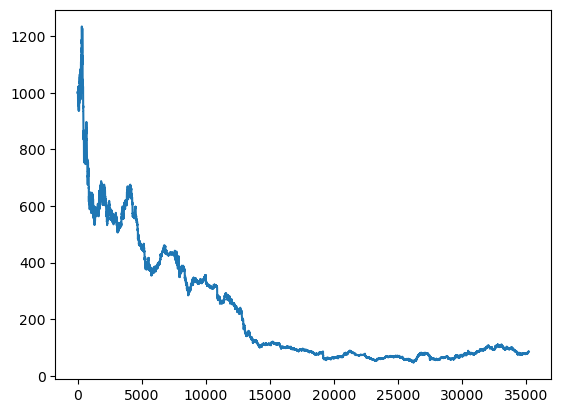

In [102]:
to_submit,trade_wise,every_day=compounding_with_stop_loss(data1,scalping,0.01,0.01)

In [14]:
scalping=pd.read_csv('~\Downloads\scalping using bb.csv')
scalping.rename(columns={'signal': 'signals'}, inplace=True)
scalping

,Unnamed: 0,datetime,open,high,low,close,volume,Upper Band,Lower Band,signals
0,0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13529.01,443.356199,NaN,NaN,0
1,1,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006,NaN,NaN,0
2,2,2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572,NaN,NaN,0
3,3,2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030,NaN,NaN,0
4,4,2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329,13533.086249,13296.229751,0
...,...,...,...,...,...,...,...,...,...,...
35203,35203,2022-01-12 01:30:00,42972.04,43095.26,42692.19,42800.38,1219.601780,42871.351049,42641.320951,-1
35204,35204,2022-01-12 02:30:00,42797.62,42823.69,42643.74,42659.20,702.103800,42865.991599,42628.264401,-1
35205,35205,2022-01-12 03:30:00,42664.71,42776.14,42597.41,42713.13,561.859930,42869.472419,42690.431581,1
35206,35206,2022-01-12 04:30:00,42713.12,42886.28,42633.97,42729.29,681.142010,42865.742364,42683.877636,1


Total Closed trades:  607
Winning trades:  316
Losing Trades:  291
Benchmark Return:  2248.9531785306435
WIN rate:  52.059308072487646  %
Gross Profit:  6714.041611256283
Net Profit:  6107.041611256283
Average Profit:  10.06102407126241
MAX Drawdowns:  18.80829015544041  %
Largest Win:  23.900548089062255
Average Win:  3.9508819308856227
Largest Loss:  -18.80829015544042
Average Loss:  -3.345391020861401
Maximum Holding Time:  7
Average Holding Duration:  1.4233937397034597
Maximum Dip:  93.54956038591551
Avg. Dip:  38.81180673375758
Sharpe Ratio:  1.0649146651009282
Sortino Ratio:  1.1706245935874169
returns:  671.4041611256284  %
Number of times stop loss met:  248
Number of times take profit met:  303


(        datetime  signals      open      high       low     close  \
 0     2018-01-01        0  13715.65  13818.55  12750.00  13135.00   
 1     2018-01-02        1  13135.00  14750.00  12890.02  14580.00   
 2     2018-01-03       -1  14576.87  15473.49  14150.00  14749.97   
 3     2018-01-04        1  14710.00  15280.00  13918.04  14811.00   
 4     2018-01-05       -1  14805.01  17118.13  14600.00  16579.00   
 ...          ...      ...       ...       ...       ...       ...   
 1468  2022-01-08        1  41707.04  42246.37  40501.00  40679.82   
 1469  2022-01-09       -1  40679.82  42300.00  40520.00  41966.99   
 1470  2022-01-10        0  41966.99  42786.70  39650.00  41604.58   
 1471  2022-01-11        1  41604.58  43100.00  41158.99  42755.00   
 1472  2022-01-12        0  42754.99  43095.26  42578.02  42675.00   
 
             volume  
 0      6970.441076  
 1     16359.347340  
 2     19457.238601  
 3     18783.876561  
 4     22383.657333  
 ...            ...  
 146

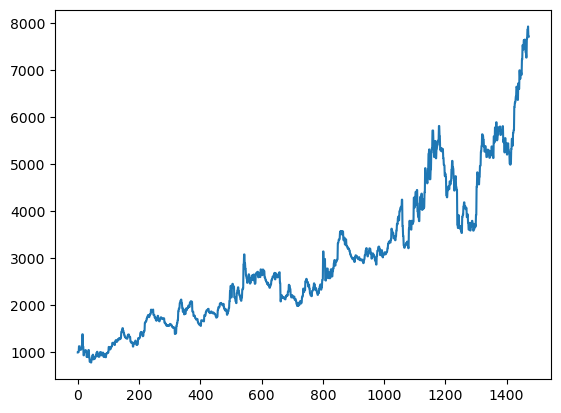

In [74]:
compounding_with_stop_loss(data,output,0.0,0.01)

In [12]:
data1=pd.read_csv(r'C:\Users\tanus\Downloads\btcusdt_1h.csv')
data1

,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13529.01,443.356199
1,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006
2,2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572
3,2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030
4,2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329
...,...,...,...,...,...,...
35203,2022-01-12 01:30:00,42972.04,43095.26,42692.19,42800.38,1219.601780
35204,2022-01-12 02:30:00,42797.62,42823.69,42643.74,42659.20,702.103800
35205,2022-01-12 03:30:00,42664.71,42776.14,42597.41,42713.13,561.859930
35206,2022-01-12 04:30:00,42713.12,42886.28,42633.97,42729.29,681.142010


In [23]:
scalping_30=pd.read_csv(r'C:\Users\tanus\Downloads\scalping using bb(30 minute).csv')
scalping_30.rename(columns={'signal': 'signals'}, inplace=True)
scalping_30

,Unnamed: 0,datetime,open,high,low,close,volume,Upper Band,Lower Band,signals
0,0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13521.12,221.752443,NaN,NaN,0
1,1,2018-01-01 06:00:00,13500.00,13690.87,13450.00,13529.01,221.603756,NaN,NaN,0
2,2,2018-01-01 06:30:00,13528.99,13595.89,13402.28,13560.00,160.399291,NaN,NaN,0
3,3,2018-01-01 07:00:00,13559.99,13559.99,13155.38,13203.06,223.297715,NaN,NaN,0
4,4,2018-01-01 07:30:00,13203.00,13411.76,13202.03,13225.00,203.728509,13540.766857,13274.509143,0
...,...,...,...,...,...,...,...,...,...,...
70394,70394,2022-01-12 03:30:00,42664.71,42733.00,42597.41,42650.75,337.739550,42779.852682,42668.427318,0
70395,70395,2022-01-12 04:00:00,42647.14,42776.14,42633.18,42713.13,224.120380,42750.692826,42661.315174,1
70396,70396,2022-01-12 04:30:00,42713.12,42886.28,42665.26,42790.01,358.331130,42745.570552,42662.289448,0
70397,70397,2022-01-12 05:00:00,42790.00,42822.21,42633.97,42729.29,322.810880,42751.006837,42665.945163,-1


In [24]:
data2=pd.read_csv(r'C:\Users\tanus\Downloads\btcusdt_30m.csv')
data2

,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13521.12,221.752443
1,2018-01-01 06:00:00,13500.00,13690.87,13450.00,13529.01,221.603756
2,2018-01-01 06:30:00,13528.99,13595.89,13402.28,13560.00,160.399291
3,2018-01-01 07:00:00,13559.99,13559.99,13155.38,13203.06,223.297715
4,2018-01-01 07:30:00,13203.00,13411.76,13202.03,13225.00,203.728509
...,...,...,...,...,...,...
70394,2022-01-12 03:30:00,42664.71,42733.00,42597.41,42650.75,337.739550
70395,2022-01-12 04:00:00,42647.14,42776.14,42633.18,42713.13,224.120380
70396,2022-01-12 04:30:00,42713.12,42886.28,42665.26,42790.01,358.331130
70397,2022-01-12 05:00:00,42790.00,42822.21,42633.97,42729.29,322.810880


Total Closed trades:  9597
Winning trades:  5111
Losing Trades:  4486
Benchmark Return:  2168.602157217745
WIN rate:  53.25622590392831  %
Gross Profit:  -928.1663697893127
Net Profit:  -10525.166369789313
Average Profit:  -1.096714220046818
MAX Drawdowns:  12.370790378006868  %
Largest Win:  8.861235524180412
Average Win:  0.6955361032622674
Largest Loss:  -12.370338678721705
Average Loss:  -0.8354539496247266
Maximum Holding Time:  34
Average Holding Duration:  4.759195581952693
Maximum Dip:  99.91045422161665
Avg. Dip:  41.51398740846423
Sharpe Ratio:  -0.6951866061429327
Sortino Ratio:  -0.6793805473426341
returns:  -92.81663697893127  %
Number of times stop loss met:  936
Number of times take profit met:  1813


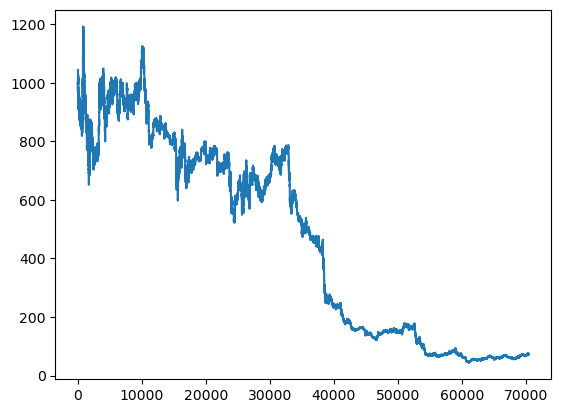

In [27]:
to_submit,trade_wise,every_day=compounding_with_stop_loss(data2,scalping_30)

STOP LOSS:  0.01
Take Profit:  0.01
Total Closed trades:  5711
Winning trades:  2993
Losing Trades:  2718
Benchmark Return:  2154.3328004044643
WIN rate:  52.40763438977412  %
Gross Profit:  -912.8382629355388
Net Profit:  -6623.838262935538
Average Profit:  -1.1598386032105652
MAX Drawdowns:  17.279886949178824  %
Largest Win:  7.851584284552149
Average Win:  0.8827579022783761
Largest Loss:  -17.279886949178834
Average Loss:  -1.0422126418531061
Maximum Holding Time:  22
Average Holding Duration:  3.498686744878305
Maximum Dip:  99.9073203649954
Avg. Dip:  45.901064096504506
Sharpe Ratio:  -0.6544672620586668
Sortino Ratio:  -0.591612810870242
returns:  -91.28382629355387  %
Number of times stop loss met:  1582
Number of times take profit met:  1378



STOP LOSS:  0.01
Take Profit:  0.02
Total Closed trades:  5334
Winning trades:  2819
Losing Trades:  2515
Benchmark Return:  2154.3328004044643
WIN rate:  52.84964379452568  %
Gross Profit:  -948.6169344568542
Net Profit:  -6282.616934

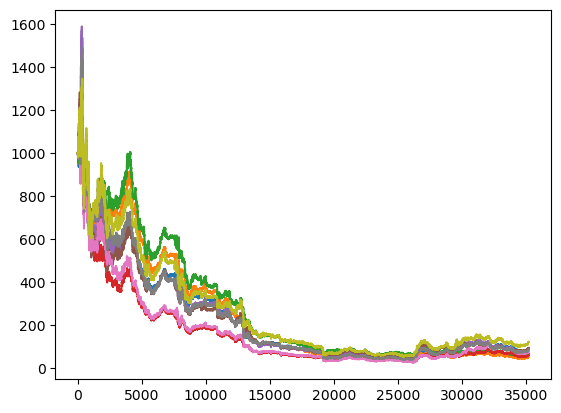

In [92]:
# 1 hour
for i in range(0,3):
    for j in range(0,3):
        stop_loss_percent=(2*i+1)/100
        take_profit_percent=(j+1)/100
        print("STOP LOSS: ",stop_loss_percent)
        print("Take Profit: ",take_profit_percent)
        compounding_with_stop_loss(data1,scalping,stop_loss_percent,take_profit_percent)
        print("\n\n")

STOP LOSS:  0.01
Take Profit:  0.01
Total Closed trades:  10388
Winning trades:  5523
Losing Trades:  4865
Benchmark Return:  2168.602157217745
WIN rate:  53.16711590296496  %
Gross Profit:  -942.5882939161647
Net Profit:  -11330.588293916164
Average Profit:  -1.0907381877085256
MAX Drawdowns:  12.370790378006868  %
Largest Win:  8.861235524180412
Average Win:  0.6622229169248255
Largest Loss:  -12.370338678721705
Average Loss:  -0.7978393792769181
Maximum Holding Time:  29
Average Holding Duration:  4.15912591451675
Maximum Dip:  99.93079930744416
Avg. Dip:  43.81339002308449
Sharpe Ratio:  -0.7590651668909076
Sortino Ratio:  -0.7184276907899882
returns:  -94.25882939161649  %
Number of times stop loss met:  2291
Number of times take profit met:  1857



STOP LOSS:  0.01
Take Profit:  0.02
Total Closed trades:  9777
Winning trades:  5253
Losing Trades:  4524
Benchmark Return:  2168.602157217745
WIN rate:  53.72813746548021  %
Gross Profit:  -960.8937989844337
Net Profit:  -10737.89379

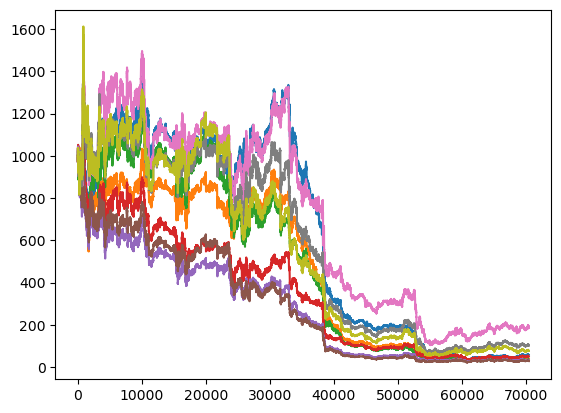

In [93]:
# 30 min
for i in range(0,3):
    for j in range(0,3):
        stop_loss_percent=(2*i+1)/100
        take_profit_percent=(j+1)/100
        print("STOP LOSS: ",stop_loss_percent)
        print("Take Profit: ",take_profit_percent)
        compounding_with_stop_loss(data2,scalping_30,stop_loss_percent,take_profit_percent)
        print("\n\n")

STOP LOSS:  0.01
Take Profit:  0.01
Total Closed trades:  607
Winning trades:  316
Losing Trades:  291
Benchmark Return:  2248.9531785306435
WIN rate:  52.059308072487646  %
Gross Profit:  6714.041611256283
Net Profit:  6107.041611256283
Average Profit:  10.06102407126241
MAX Drawdowns:  18.80829015544041  %
Largest Win:  23.900548089062255
Average Win:  3.9508819308856227
Largest Loss:  -18.80829015544042
Average Loss:  -3.345391020861401
Maximum Holding Time:  7
Average Holding Duration:  1.4233937397034597
Maximum Dip:  93.54956038591551
Avg. Dip:  38.81180673375758
Sharpe Ratio:  1.0649146651009282
Sortino Ratio:  1.1706245935874169
returns:  671.4041611256284  %
Number of times stop loss met:  248
Number of times take profit met:  303



STOP LOSS:  0.01
Take Profit:  0.02
Total Closed trades:  557
Winning trades:  284
Losing Trades:  273
Benchmark Return:  2248.9531785306435
WIN rate:  50.987432675044886  %
Gross Profit:  2307.2584719503193
Net Profit:  1750.2584719503193
Average

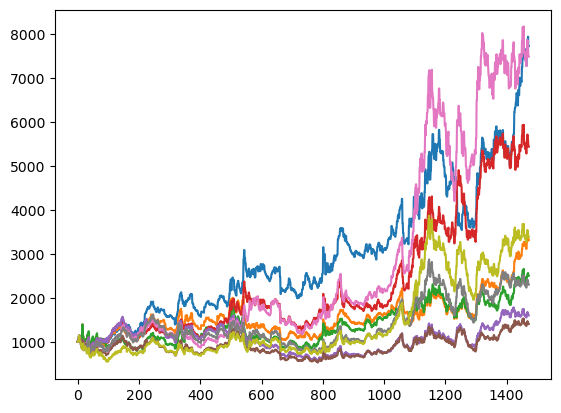

In [94]:
# MACD 1 day
for i in range(0,3):
    for j in range(0,3):
        stop_loss_percent=(2*i+1)/100
        take_profit_percent=(j+1)/100
        print("STOP LOSS: ",stop_loss_percent)
        print("Take Profit: ",take_profit_percent)
        compounding_with_stop_loss(data,output,stop_loss_percent,take_profit_percent)
        print("\n\n")

In [99]:
signals=pd.read_csv(r'C:\Users\tanus\Downloads\signals.csv')
signals

,Unnamed: 0,datetime,high,low,close,open,volume,TR,ATR,signals,Upper Channel,Lower Channel
0,0,2018-01-01,13818.55,12750.00,13135.00,13715.65,6970.441076,NaN,NaN,0,NaN,NaN
1,1,2018-01-02,14750.00,12890.02,14580.00,13135.00,16359.347340,1859.98,NaN,0,NaN,NaN
2,2,2018-01-03,15473.49,14150.00,14749.97,14576.87,19457.238601,1323.49,NaN,0,NaN,NaN
3,3,2018-01-04,15280.00,13918.04,14811.00,14710.00,18783.876561,1361.96,NaN,0,NaN,NaN
4,4,2018-01-05,17118.13,14600.00,16579.00,14805.01,22383.657333,2518.13,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1468,1468,2022-01-08,42246.37,40501.00,40679.82,41707.04,27031.900870,1745.37,2396.496,0,43076.316,38283.324
1469,1469,2022-01-09,42300.00,40520.00,41966.99,40679.82,27291.009660,1780.00,2340.988,0,44307.978,39626.002
1470,1470,2022-01-10,42786.70,39650.00,41604.58,41966.99,51064.904360,3136.70,2664.328,0,44268.908,38940.252
1471,1471,2022-01-11,43100.00,41158.99,42755.00,41604.58,38062.818280,1941.01,2314.876,0,45069.876,40440.124


STOP LOSS:  0.01
Take Profit:  0.01
Total Closed trades:  607
Winning trades:  316
Losing Trades:  291
Benchmark Return:  2248.9531785306435
WIN rate:  52.059308072487646  %
Gross Profit:  6714.041611256283
Net Profit:  6107.041611256283
Average Profit:  10.06102407126241
MAX Drawdowns:  18.80829015544041  %
Largest Win:  23.900548089062255
Average Win:  3.9508819308856227
Largest Loss:  -18.80829015544042
Average Loss:  -3.345391020861401
Maximum Holding Time:  7
Average Holding Duration:  1.4233937397034597
Maximum Dip:  93.54956038591551
Avg. Dip:  38.81180673375758
Sharpe Ratio:  1.0649146651009282
Sortino Ratio:  1.1706245935874169
returns:  671.4041611256284  %
Number of times stop loss met:  248
Number of times take profit met:  303



STOP LOSS:  0.01
Take Profit:  0.02
Total Closed trades:  557
Winning trades:  284
Losing Trades:  273
Benchmark Return:  2248.9531785306435
WIN rate:  50.987432675044886  %
Gross Profit:  2307.2584719503193
Net Profit:  1750.2584719503193
Average

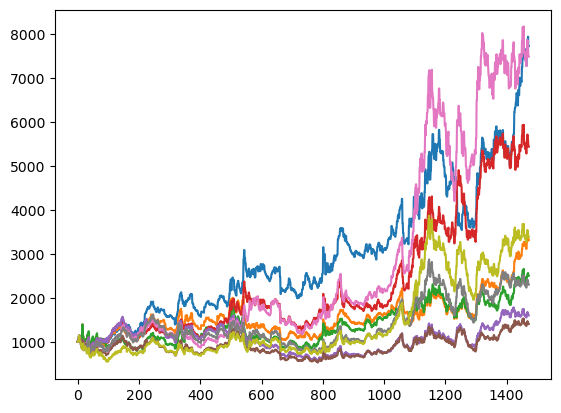

In [96]:
# MACD 1 day
for i in range(0,3):
    for j in range(0,3):
        stop_loss_percent=(2*i+1)/100
        take_profit_percent=(j+1)/100
        print("STOP LOSS: ",stop_loss_percent)
        print("Take Profit: ",take_profit_percent)
        compounding_with_stop_loss(data,output,stop_loss_percent,take_profit_percent)
        print("\n\n")

Total Closed trades:  252
Winning trades:  133
Losing Trades:  119
Benchmark Return:  2248.9531785306435
WIN rate:  52.77777777777778  %
Gross Profit:  6865.021391405013
Net Profit:  6613.021391405013
Average Profit:  26.24214837859132
MAX Drawdowns:  18.80829015544041  %
Largest Win:  27.4984596087406
Average Win:  7.776331877827878
Largest Loss:  -18.80829015544041
Average Loss:  -6.172952101703447
Maximum Holding Time:  20
Average Holding Duration:  4.841269841269841
Maximum Dip:  93.97542176971973
Avg. Dip:  38.49762935242394
Sharpe Ratio:  1.0147834942043874
Sortino Ratio:  1.352797890558359
returns:  686.5021391405013  %
Number of times stop loss met:  123
Number of times take profit met:  56


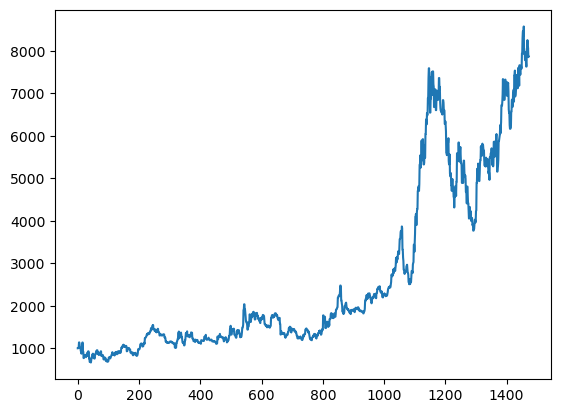

In [100]:
compounding_with_stop_loss(data,output,0.05,0.1)

In [97]:
signals=pd.read_csv(r'C:\Users\tanus\Downloads\Macd+Volty Expan.csv')
signals

,Unnamed: 0,datetime,high,low,close,open,volume,signals
0,0,2018-01-01,13818.55,12750.00,13135.00,13715.65,6970.441076,0
1,1,2018-01-02,14750.00,12890.02,14580.00,13135.00,16359.347340,0
2,2,2018-01-03,15473.49,14150.00,14749.97,14576.87,19457.238601,0
3,3,2018-01-04,15280.00,13918.04,14811.00,14710.00,18783.876561,0
4,4,2018-01-05,17118.13,14600.00,16579.00,14805.01,22383.657333,0
...,...,...,...,...,...,...,...,...
1468,1468,2022-01-08,42246.37,40501.00,40679.82,41707.04,27031.900870,0
1469,1469,2022-01-09,42300.00,40520.00,41966.99,40679.82,27291.009660,0
1470,1470,2022-01-10,42786.70,39650.00,41604.58,41966.99,51064.904360,0
1471,1471,2022-01-11,43100.00,41158.99,42755.00,41604.58,38062.818280,0


STOP LOSS:  0.01
Take Profit:  0.01
Total Closed trades:  607
Winning trades:  316
Losing Trades:  291
Benchmark Return:  2248.9531785306435
WIN rate:  52.059308072487646  %
Gross Profit:  6714.041611256283
Net Profit:  6107.041611256283
Average Profit:  10.06102407126241
MAX Drawdowns:  18.80829015544041  %
Largest Win:  23.900548089062255
Average Win:  3.9508819308856227
Largest Loss:  -18.80829015544042
Average Loss:  -3.345391020861401
Maximum Holding Time:  7
Average Holding Duration:  1.4233937397034597
Maximum Dip:  93.54956038591551
Avg. Dip:  38.81180673375758
Sharpe Ratio:  1.0649146651009282
Sortino Ratio:  1.1706245935874169
returns:  671.4041611256284  %
Number of times stop loss met:  248
Number of times take profit met:  303



STOP LOSS:  0.01
Take Profit:  0.02
Total Closed trades:  557
Winning trades:  284
Losing Trades:  273
Benchmark Return:  2248.9531785306435
WIN rate:  50.987432675044886  %
Gross Profit:  2307.2584719503193
Net Profit:  1750.2584719503193
Average

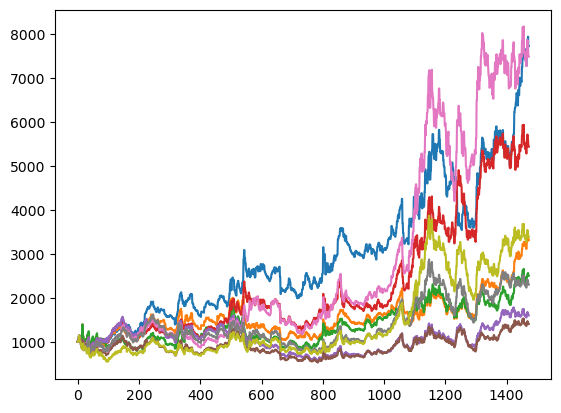

In [98]:
# MACD 1 day
for i in range(0,3):
    for j in range(0,3):
        stop_loss_percent=(2*i+1)/100
        take_profit_percent=(j+1)/100
        print("STOP LOSS: ",stop_loss_percent)
        print("Take Profit: ",take_profit_percent)
        compounding_with_stop_loss(data,output,stop_loss_percent,take_profit_percent)
        print("\n\n")